In [2]:
#Import Statements
import xarray as xr
import gcsfs
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import intake
from scipy.signal import detrend

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
#ds.dt 
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time[1:-1].values 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#mask
def atlMask(newMask):
    #mask[ydimension, xdimnesion]
    newMask[215:, 0:147] = 0 #fixes top left pixel
    newMask[215:, 260:] = 0
    newMask[185:215, :120] = 0
    newMask[185:215, 260:] = 0 #right 
    newMask[185:199, 250:] = 0 #right
    newMask[:185, :133] = 0 #responsible for bottom left pixel
    newMask[:180, :141] = 0 #fixse bottom left pixeel 
    newMask[:185, 245:] = 0
    newMask[115:145, 135:155] = 0
    for j in coords.j[55:125]:
        for i in coords.i[205:245]:
            if j < (7/4)*i - 303.75:
                newMask[j,i] = 0
    return newMask
mask = atlMask(coords.hFacS.isel(k=0).load())

In [8]:
#For use later 
#Advection term - deg C m^3 per second 
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * mask * rho0 * cp)[:, :, 220, :] #(time, l3_c, i)
a

<xarray.DataArray (time: 288, l3_c: 221, i: 360)>
dask.array<shape=(288, 221, 360), dtype=float64, chunksize=(1, 221, 90)>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * l3_c     (l3_c) int64 0 1 2 3 4 5 6 7 8 ... 213 214 215 216 217 218 219 220
    j_g      int64 220
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    k        int64 0

In [9]:
#Top left region
top_left = a[:, :103, :190].sum(['i','l3_c'])
top_left.load()

<xarray.DataArray (time: 288)>
array([5.642634e+14, 5.818314e+14, 6.591598e+14, ..., 7.628606e+14,
       7.877606e+14, 5.934690e+14])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 220
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    k        int64 0

In [10]:
#Top left with 79 instead 
top_left79 = a[:, :103, :189].sum(['i','l3_c'])
top_left79.load()

<xarray.DataArray (time: 288)>
array([5.211422e+14, 5.564206e+14, 6.247993e+14, ..., 7.155061e+14,
       7.518134e+14, 5.745004e+14])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 220
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    k        int64 0

In [ ]:
#Plot 
fig, ax = plt.subplots(figsize=(12,4))
(top_left).plot(ax=ax)
(top_left79).plot(ax=ax, ls='--')

In [11]:
#Top right region 
top_right = a[:, :103, 190:].sum(['i','l3_c'])
top_right.load()

<xarray.DataArray (time: 288)>
array([ 1.879053e+14, -6.718858e+13, -1.407876e+14, ...,  6.999572e+13,
       -5.503357e+13,  4.739107e+13])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 220
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    k        int64 0

In [12]:
#Top right with 79 
top_right79 = a[:, :103, 189:].sum(['i','l3_c'])
top_right79.load()

<xarray.DataArray (time: 288)>
array([ 2.310265e+14, -4.177777e+13, -1.064271e+14, ...,  1.173501e+14,
       -1.908636e+13,  6.635972e+13])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 220
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    k        int64 0

In [ ]:
#Plot
fig, ax = plt.subplots(figsize=(12,4))
(top_right).plot(ax=ax)
(top_right79).plot(ax=ax, ls='--')

In [ ]:
#Plot 
fig, ax = plt.subplots(figsize=(12,4))
(top_right).plot(ax=ax)
(top_right79).plot(ax=ax, ls='--')

In [13]:
#Bottom  region 
bottom = a[:, 103:, :].sum(['i','l3_c'])
bottom.load()

<xarray.DataArray (time: 288)>
array([-2.470770e+14, -2.044361e+14, -2.054368e+14, ..., -2.606589e+14,
       -2.497540e+14, -2.140274e+14])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 220
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    k        int64 0

In [14]:
#Strip transport with 0.83 factor 
strip = (a[:, :103, 189:190].sum(['i','l3_c']))* 0.83
strip.load()

<xarray.DataArray (time: 288)>
array([3.579059e+13, 2.109097e+13, 2.851924e+13, ..., 3.930417e+13,
       2.983618e+13, 1.574399e+13])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 220
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    k        int64 0

In [15]:
#Interpolated
adv_interp_left = top_left79 + strip 
adv_interp_right = top_left + top_right - adv_interp_left

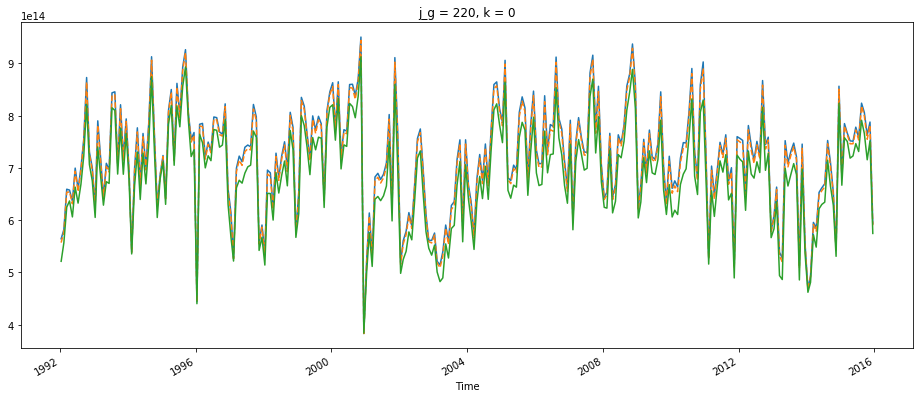

In [49]:
#Plot 
fig, ax = plt.subplots(figsize=(16,6))
(top_left).plot(ax=ax)
(adv_interp_left).plot(ax=ax, ls='--')
(top_left79).plot(ax=ax)

In [20]:
#Time series 
#adv_time = (adv_interp * ds.dt)
#adv_time.cumsum('time').plot()

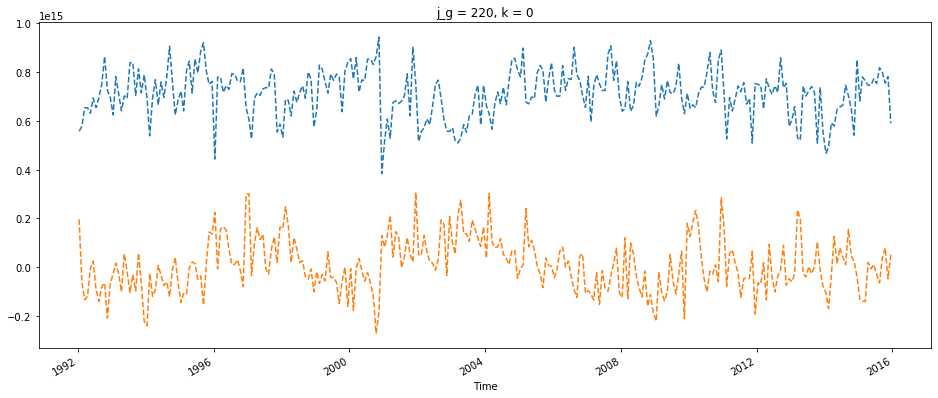

In [19]:
#Plot 
fig, ax = plt.subplots(figsize=(16,6))
(adv_interp_left).plot(ax=ax, ls='--')
(adv_interp_right).plot(ax=ax, ls='--')

In [16]:
#Vars
interp_left_cs = adv_interp_left.cumsum('time')
interp_right_cs= adv_interp_right.cumsum('time')

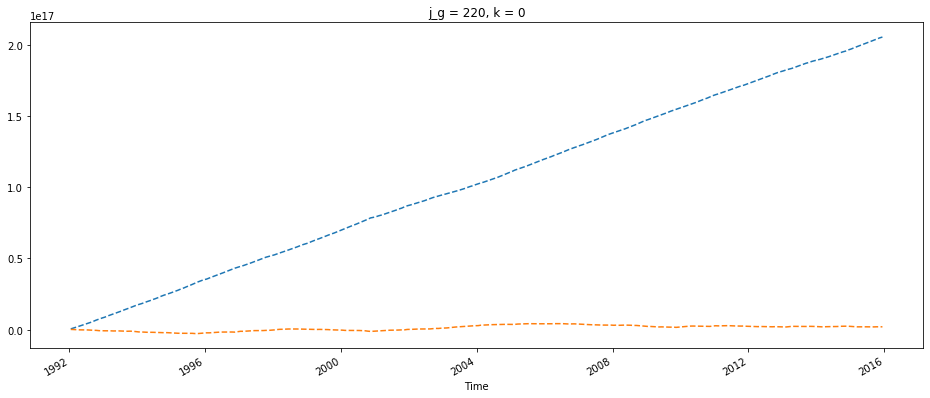

In [17]:
#Plot 
fig, ax = plt.subplots(figsize=(16,6))
(interp_left_cs).plot(ax=ax, ls='--')
((interp_right_cs).cumsum('time')).plot(ax=ax, ls='--')

In [17]:
interp_left_detrend = xr.apply_ufunc(detrend, interp_left_cs.load().fillna(0),kwargs={'axis': 0}).where(~interp_left_cs.isnull())
interp_right_detrend = xr.apply_ufunc(detrend, interp_right_cs.load().fillna(0),kwargs={'axis': 0}).where(~interp_right_cs.isnull())

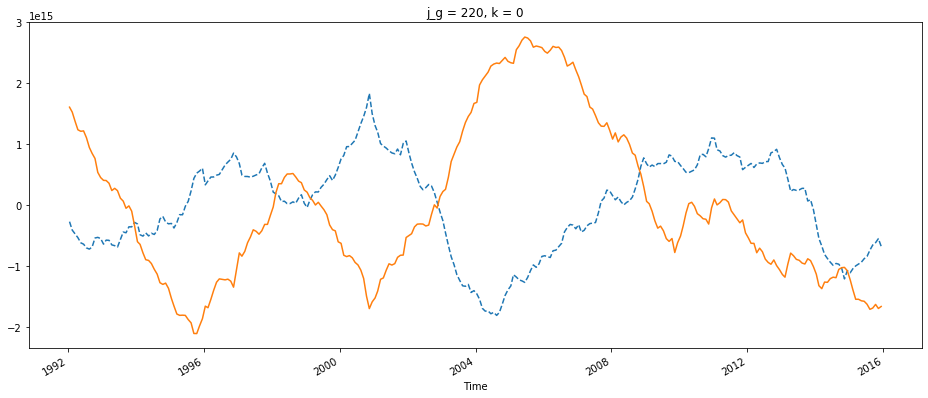

In [27]:
#Plot 
fig, ax = plt.subplots(figsize=(16,6))
(interp_left_detrend).plot(ax=ax, ls='--')
(interp_right_detrend).plot(ax=ax)

In [18]:
#Getting box sizes - top left 
s = ds.LaHs3RHO.isel(j_g=220)
left_size = (s[:, :103, :190] * coords.dxG[220, :190]).sum(['i','l3_c'])

In [19]:
#top right, bottom box size
right_size = (s[:, :103, 190:] * coords.dxG[220, 190:]).sum(['i','l3_c'])
bottom_size = (s[:, 103:, :] * coords.dxG[220, :]).sum(['i','l3_c'])

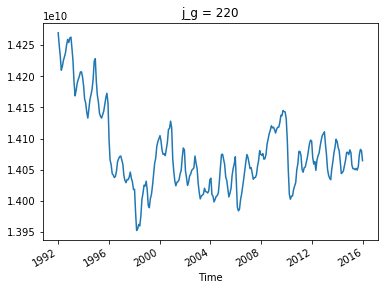

In [20]:
left_size.plot()

In [ ]:
right_size.plot()

In [ ]:
bottom_size.plot()

In [21]:
#Throughflow 
v = ((ds.VVELMASS[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k']) 
area =( coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k'])
t = ((ds.THETA[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k'])

net_tf_adv = (v * t) / (area*area)
net_tf_adv

<xarray.DataArray (time: 288)>
dask.array<shape=(288,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    j_g      int64 220
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    j        int64 220

In [30]:
#REgional throughflow advection - multiplying by rh0 and cp after integral (same as doing it before )
topleft_tf_adv = net_tf_adv * left_size* rho0 * cp
topright_tf_adv = net_tf_adv * right_size * rho0 * cp
bottom_tf_adv = net_tf_adv * bottom_size * rho0 * cp

In [31]:
#net- removing throughflow first from the linearly interpolated number and then cumsumming
left_net = (adv_interp_left - topleft_tf_adv).cumsum('time')
right_net = (adv_interp_right - topright_tf_adv).cumsum('time')
bottom_net = (bottom - bottom_tf_adv).cumsum('time')

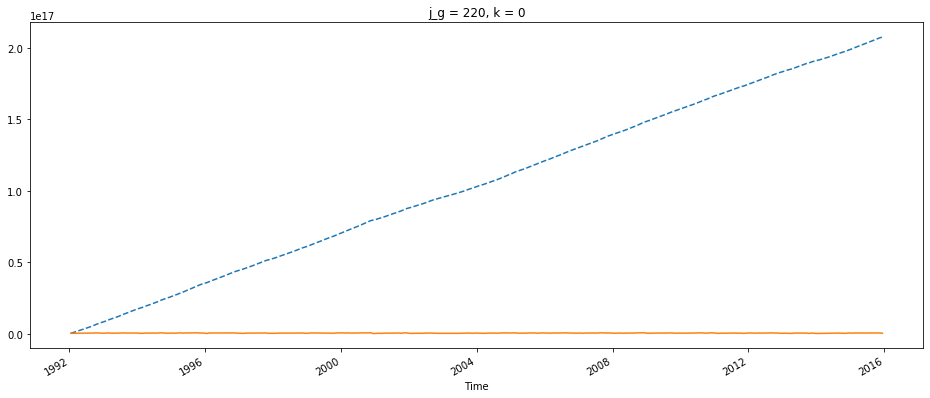

In [32]:
#Plotting left with and without throughflow on the same axis - not detrended 
fig, ax = plt.subplots(figsize=(16,6))
(left_net).plot(ax=ax, ls='--')
(adv_interp_left).plot(ax=ax)

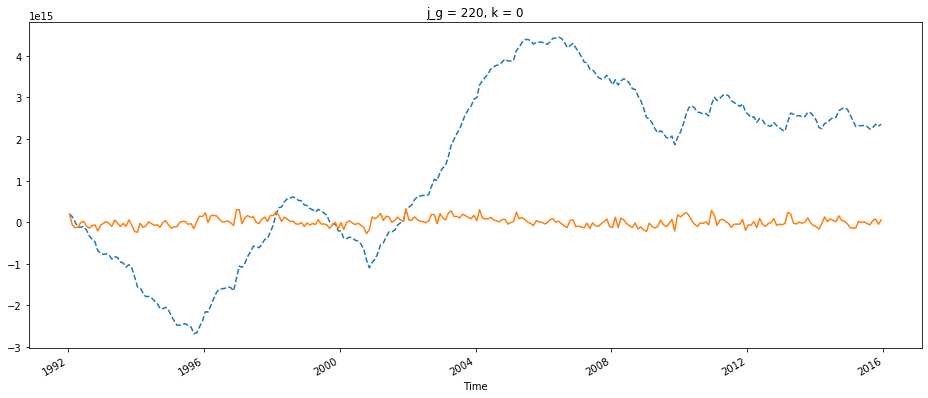

In [33]:
#Plotting right with and without throughflow on the same axis - not detrended 
fig, ax = plt.subplots(figsize=(16,6))
(right_net).plot(ax=ax, ls='--')
(adv_interp_right).plot(ax=ax)

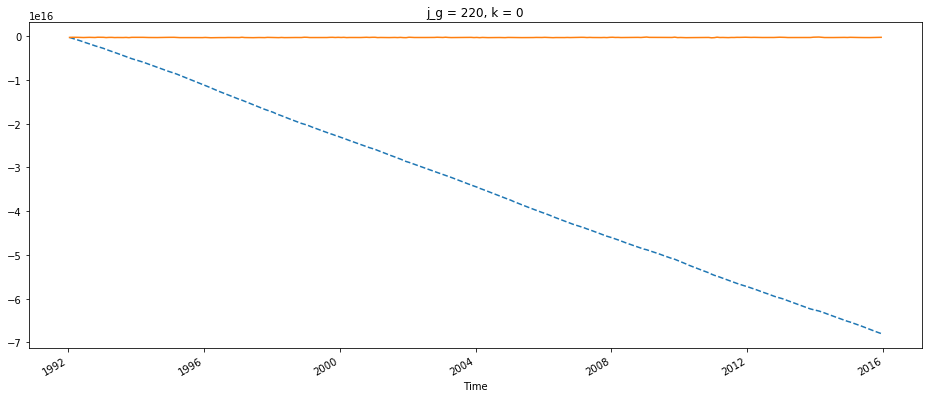

In [34]:
#Plotting bottom with and without throughflow on the same axis - not detrended 
fig, ax = plt.subplots(figsize=(16,6))
(bottom_net).plot(ax=ax, ls='--')
(bottom).plot(ax=ax)

In [35]:
#Detrending after cumsumming
left_net_detrend = xr.apply_ufunc(detrend, left_net.load().fillna(0),kwargs={'axis': 0}).where(~left_net.isnull())
right_net_detrend = xr.apply_ufunc(detrend, right_net.load().fillna(0),kwargs={'axis': 0}).where(~right_net.isnull())
bottom_net_detrend = xr.apply_ufunc(detrend, bottom_net.load().fillna(0),kwargs={'axis': 0}).where(~bottom_net.isnull())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-268a56a17f73>", line 3, in <module>
    right_net_detrend = xr.apply_ufunc(detrend, right_net.load().fillna(0),kwargs={'axis': 0}).where(~right_net.isnull())
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/core/dataarray.py", line 727, in load
    ds = self._to_temp_dataset().load(**kwargs)
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/core/dataset.py", line 550, in load
    evaluated_data = da.compute(*lazy_data.values(), **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/dask/base.py", line 446, in compute
    results = schedule(dsk, keys, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.6/site-packages/dask/threaded.py", line 82, in get
    **kwargs
  File "/srv/conda/envs/notebook/lib/

KeyboardInterrupt: 

In [ ]:
#Detrended plots 
left_net_detrend.plot()

In [ ]:
right_net_detrend.plot()

In [ ]:
bottom_net_detrend.plot()